In [1]:
# python libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# magic
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# hacks
import os
import sys
nb_dir = os.path.split(os.path.abspath(os.getcwd()))[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

### Test Files:

In [4]:
import Bfield

### Regeneration:

In [5]:
# If you want to fetch the current rendered model
# Happens nearly instantly.
Bdict = Bfield.precompute()

In [5]:
### uncomment to force regeneration (takes about 5 hours)
### there's no need to do it unless higher resolution is needed..
#Bdict = Bfield.precompute(autoload=False)

  progress: 99.9%   elapsed: 17161.53 [sec]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [6]:
Bdict.keys()

['y', 'x', 'z', 'BX', 'BY', 'BZ']

In [7]:
Bdict['x'].shape

(120L,)

In [8]:
Bdict['BX'].shape

(120L, 120L, 120L)

# Sun Plots

z = 0.1 [AU]
B_rho (-),  B_theta (+),  B_z (+)


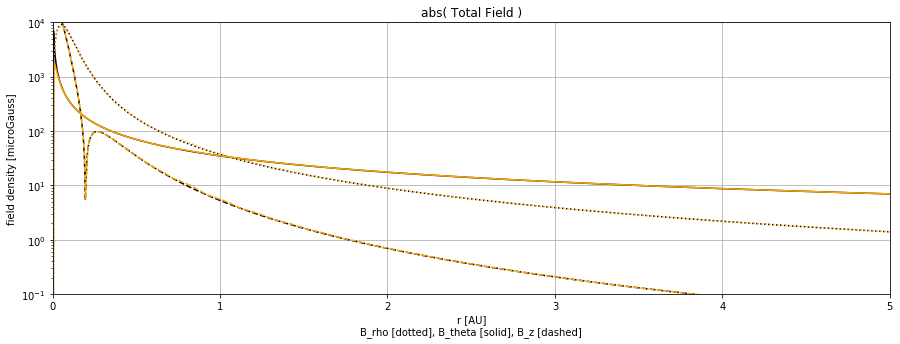

In [9]:
import Transform
import SolarMagneticModel

def plotPolar(z=.1):
    """Plot total solar magnetic field model by polar coordinates.
    Uses EMR approximation for the ring component.
    Black lines come from SolarMagneticModel
    Orange lines come from interpolation from a precomputation.
    """
    print 'z = {} [AU]'.format(z)
    r_list = np.linspace(0, 5, 1000) # [AU]
    # q for quick (Bfield), s for slow (SolarMagneticModel)
    qB_rho   = []
    qB_theta = []
    qB_z     = []
    sB_rho   = []
    sB_theta = []
    sB_z     = []    
    for r in r_list:
        cartesian_pos = np.array([ r, 0, z ] ) # [AU]
        Gauss2Tesla = 1e4 # [Gauss / Tesla]
        cartesian_qB = Bfield.cartesianTesla(cartesian_pos) * Gauss2Tesla # [Gauss]
        cartesian_sB = SolarMagneticModel.sumBfieldGauss(cartesian_pos)   # [Gauss]        
        polar_qB = Transform.cartesian2polar( cartesian_pos, cartesian_qB )['vec']
        polar_sB = Transform.cartesian2polar( cartesian_pos, cartesian_sB )['vec']        
        qB_rho.append(  polar_qB[0])
        qB_theta.append(polar_qB[1])
        qB_z.append(    polar_qB[2])
        sB_rho.append(  polar_sB[0])
        sB_theta.append(polar_sB[1])
        sB_z.append(    polar_sB[2])
    
    if qB_rho[-1] >= 0:
        print 'B_rho (+), ',
    else:
        print 'B_rho (-), ',

    if qB_theta[-1] >= 0:
        print 'B_theta (+), ',
    else:
        print 'B_theta (-), ',

    if qB_z[-1] >= 0:
        print 'B_z (+)'
    else:
        print 'B_z (-)'
    
    qB_rho   = np.abs( qB_rho   ) * 1e6 # [microGauss]
    qB_theta = np.abs( qB_theta ) * 1e6 # [microGauss]
    qB_z     = np.abs( qB_z     ) * 1e6 # [microGauss]
    sB_rho   = np.abs( sB_rho   ) * 1e6 # [microGauss]
    sB_theta = np.abs( sB_theta ) * 1e6 # [microGauss]
    sB_z     = np.abs( sB_z     ) * 1e6 # [microGauss]
    
    plt.figure(figsize=(15,5))
    plt.yscale('log')
    plt.xlim(0,5)
    plt.ylim(.1,1e4)
    plt.grid(True)
    plt.xlabel('r [AU]\n' + 'B_rho [dotted], B_theta [solid], B_z [dashed]')
    plt.ylabel('field density [microGauss]')
    plt.title('abs( Total Field )')
    
    plt.plot( r_list, sB_rho, color='black', linestyle='dotted' )
    plt.plot( r_list, sB_theta, color='black', linestyle='solid' )
    plt.plot( r_list, sB_z, color='black', linestyle='dashed' )

    plt.plot( r_list, qB_rho, color='orange', linestyle='dotted' )
    plt.plot( r_list, qB_theta, color='orange', linestyle='solid' )
    plt.plot( r_list, qB_z, color='orange', linestyle='dashed' )

plotPolar()

# Performance race

In [5]:
import random
import time
import Bfield
import SolarMagneticModel

def interpolate(positions):
    with open('interpolate.field','w') as f:
        start = time.time()
        for position in positions:
            position = np.array(position)
            B = Bfield.cartesianTesla(position)
    return time.time() - start

def compute(positions):
    with open('compute.field','w') as f:
        start = time.time()
        for position in positions:
            position = np.array(position)
            B = SolarMagneticModel.sumBfieldTesla(position)
    return time.time() - start


In [7]:
spacelimit = 6
samples = 10000
np.random.seed(12345)
x = np.random.uniform(-spacelimit, spacelimit, samples)
y = np.random.uniform(-spacelimit, spacelimit, samples)
z = np.random.uniform(-spacelimit, spacelimit, samples)

positions = np.array(zip(x, y, z))
int_time = interpolate(positions)
comp_time = compute(positions)

print 'computational time for {} samples: {} [seconds]'.format(samples,comp_time)
print 'interpolation time for {} samples: {} [seconds]'.format(samples,int_time)
print 'performance ratio (comp/interp): {:.3}x'.format(comp_time/float(int_time))

computational time for 10000 samples: 106.963000059 [seconds]
interpolation time for 10000 samples: 7.28099989891 [seconds]
performance ratio (comp/interp): 14.7x


# Z vs Y Field near sun

In [96]:
# Z-Y meridian plane (x = 0)
Ro = 0.00465 # radius of Sun in [AU]
w = 50.* Ro
Z, Y = np.mgrid[-w:w:500j,-w:w:500j]
z = Z.flatten()
y = Y.flatten()
size = z.size
x = np.zeros(size)

bx = np.zeros(size)
bz = np.zeros(size)
by = np.zeros(size)
for i, (ix, iy, iz) in enumerate(zip(x, y, z)):
    position = np.array([ix, iy, iz])
    bx[i], by[i], bz[i] = Bfield.cartesianTesla(position)

BX = bx.reshape(Z.shape)
BY = by.reshape(Z.shape)
BZ = bz.reshape(Z.shape)

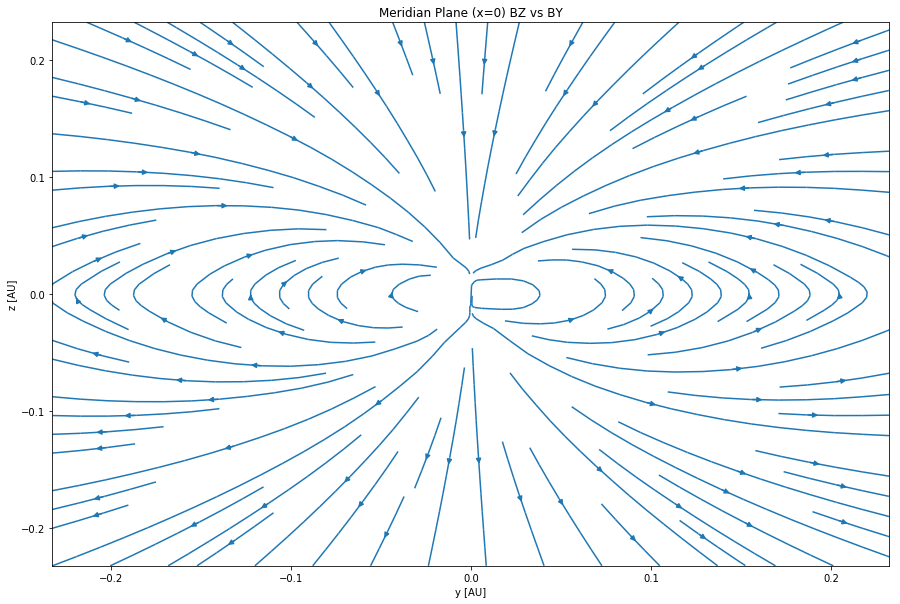

In [97]:
# plot it
plt.figure(figsize=(15,10))
plt.xlim(-w,w) # actually y-axis
plt.ylim(-w,w) # actually z-axis
plt.xlabel('y [AU]')
plt.ylabel('z [AU]')
plt.title('Meridian Plane (x=0) BZ vs BY')
plt.streamplot(Y,Z,BY,BZ)

# Y vs X near sun

In [100]:
# Y-X equitorial plane (z = 0)
Ro = 0.00465 # radius of Sun in [AU]
w = 50.* Ro
Y, X = np.mgrid[-w:w:500j,-w:w:500j]
y = Y.flatten()
x = X.flatten()
size = z.size
z = np.zeros(size)

bx = np.zeros(size)
bz = np.zeros(size)
by = np.zeros(size)
for i, (ix, iy, iz) in enumerate(zip(x, y, z)):
    position = np.array([ix, iy, iz])
    bx[i], by[i], bz[i] = Bfield.cartesianTesla(position)

BX = bx.reshape(Y.shape)
BY = by.reshape(Y.shape)
BZ = bz.reshape(Y.shape)

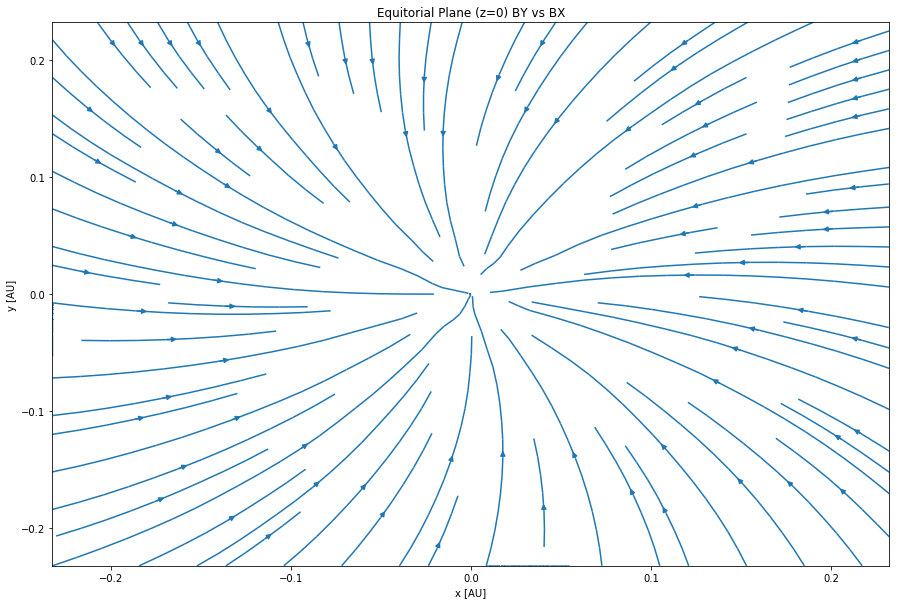

In [102]:
# plot it
plt.figure(figsize=(15,10))
plt.xlim(-w,w) # actually x-axis
plt.ylim(-w,w) # actually y-axis
plt.xlabel('x [AU]')
plt.ylabel('y [AU]')
plt.title('Equitorial Plane (z=0) BY vs BX')
plt.streamplot(X,Y,BX,BY)

# Z vs Y Field near Earth

In [103]:
# Z-Y meridian plane (x = 1)
Ro = 0.00465 # radius of Sun in [AU]
w = 50.* Ro
Z, Y = np.mgrid[-w:w:500j,-w:w:500j]
z = Z.flatten()
y = Y.flatten()
size = z.size
x = np.ones(size)

bx = np.zeros(size)
bz = np.zeros(size)
by = np.zeros(size)
for i, (ix, iy, iz) in enumerate(zip(x, y, z)):
    position = np.array([ix, iy, iz])
    bx[i], by[i], bz[i] = Bfield.cartesianTesla(position)

BX = bx.reshape(Z.shape)
BY = by.reshape(Z.shape)
BZ = bz.reshape(Z.shape)

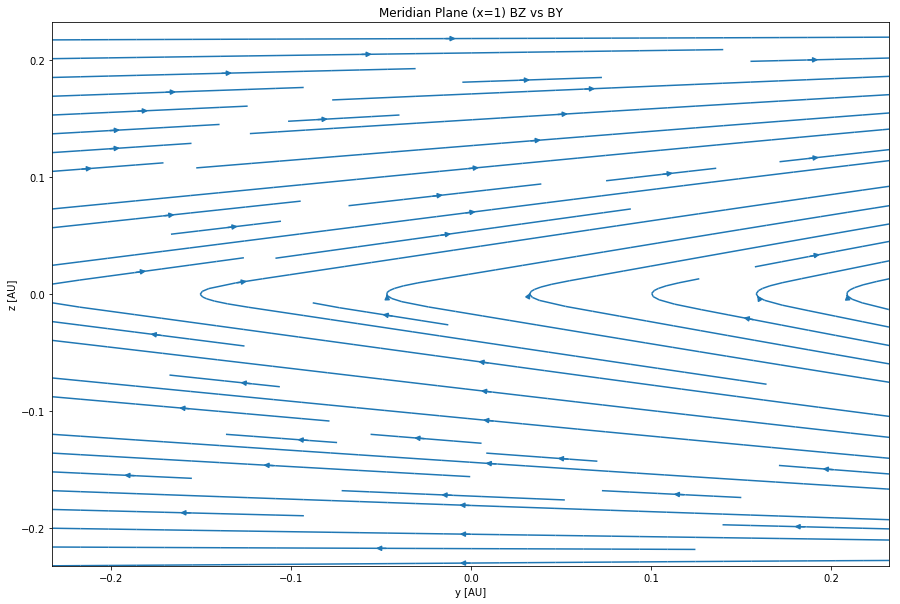

In [104]:
# plot it
plt.figure(figsize=(15,10))
plt.xlim(-w,w) # actually y-axis
plt.ylim(-w,w) # actually z-axis
plt.xlabel('y [AU]')
plt.ylabel('z [AU]')
plt.title('Meridian Plane (x=1) BZ vs BY')
plt.streamplot(Y,Z,BY,BZ)

# Y vs X near earth

In [105]:
# Y-X equitorial plane (z = 0)
Ro = 0.00465 # radius of Sun in [AU]
w = 50.* Ro
Y, X = np.mgrid[-w:w:500j,1-w:1+w:500j]
y = Y.flatten()
x = X.flatten()
size = z.size
z = np.zeros(size)

bx = np.zeros(size)
bz = np.zeros(size)
by = np.zeros(size)
for i, (ix, iy, iz) in enumerate(zip(x, y, z)):
    position = np.array([ix, iy, iz])
    bx[i], by[i], bz[i] = Bfield.cartesianTesla(position)

BX = bx.reshape(Y.shape)
BY = by.reshape(Y.shape)
BZ = bz.reshape(Y.shape)

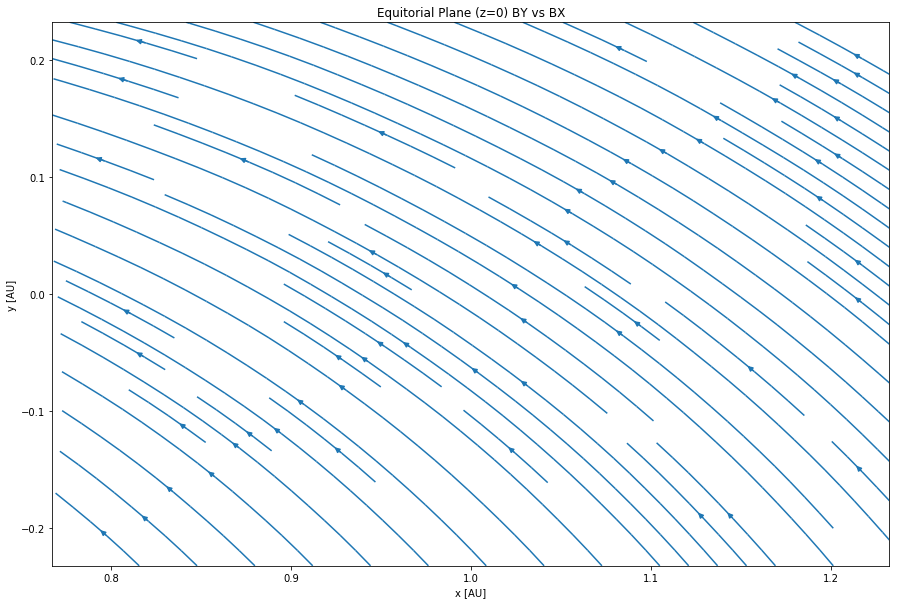

In [112]:
# plot it
plt.figure(figsize=(15,10))
plt.xlim(1-w,1+w) # actually x-axis
plt.ylim(-w,w) # actually y-axis
plt.xlabel('x [AU]')
plt.ylabel('y [AU]')
plt.title('Equitorial Plane (z=0) BY vs BX')
plt.streamplot(X,Y,BX,BY)

# Z vs Y full range

In [113]:
# Z-Y meridian plane (x = 0)
w = 6.
Z, Y = np.mgrid[-w:w:500j,-w:w:500j]
z = Z.flatten()
y = Y.flatten()
size = z.size
x = np.zeros(size)

bx = np.zeros(size)
bz = np.zeros(size)
by = np.zeros(size)
for i, (ix, iy, iz) in enumerate(zip(x, y, z)):
    position = np.array([ix, iy, iz])
    bx[i], by[i], bz[i] = Bfield.cartesianTesla(position)

BX = bx.reshape(Z.shape)
BY = by.reshape(Z.shape)
BZ = bz.reshape(Z.shape)

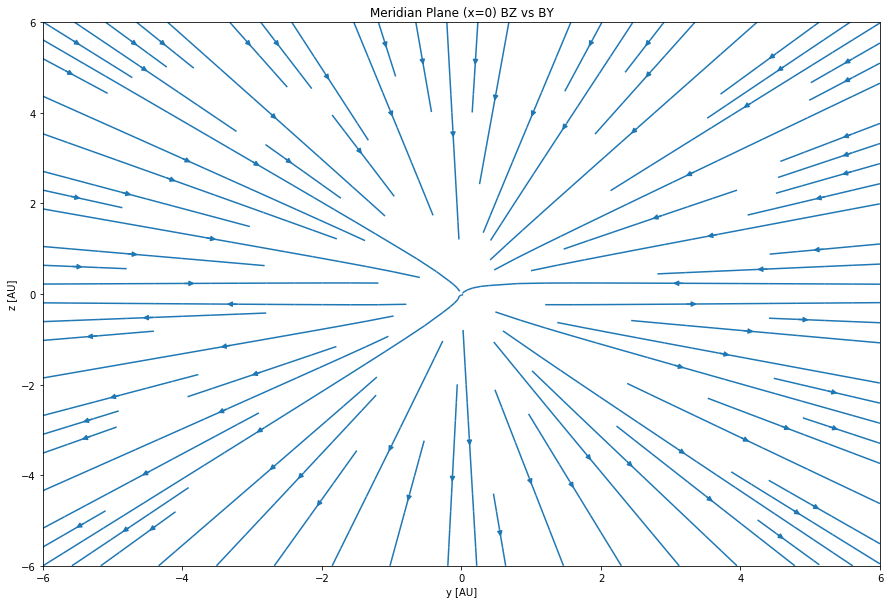

In [114]:
# plot it
plt.figure(figsize=(15,10))
plt.xlim(-w,w) # actually y-axis
plt.ylim(-w,w) # actually z-axis
plt.xlabel('y [AU]')
plt.ylabel('z [AU]')
plt.title('Meridian Plane (x=0) BZ vs BY')
plt.streamplot(Y,Z,BY,BZ)

# Y vs X full range

In [115]:
# Y-X equitorial plane (z = 0)
w = 6.
Y, X = np.mgrid[-w:w:500j,-w:w:500j]
y = Y.flatten()
x = X.flatten()
size = z.size
z = np.zeros(size)

bx = np.zeros(size)
bz = np.zeros(size)
by = np.zeros(size)
for i, (ix, iy, iz) in enumerate(zip(x, y, z)):
    position = np.array([ix, iy, iz])
    bx[i], by[i], bz[i] = Bfield.cartesianTesla(position)

BX = bx.reshape(Y.shape)
BY = by.reshape(Y.shape)
BZ = bz.reshape(Y.shape)

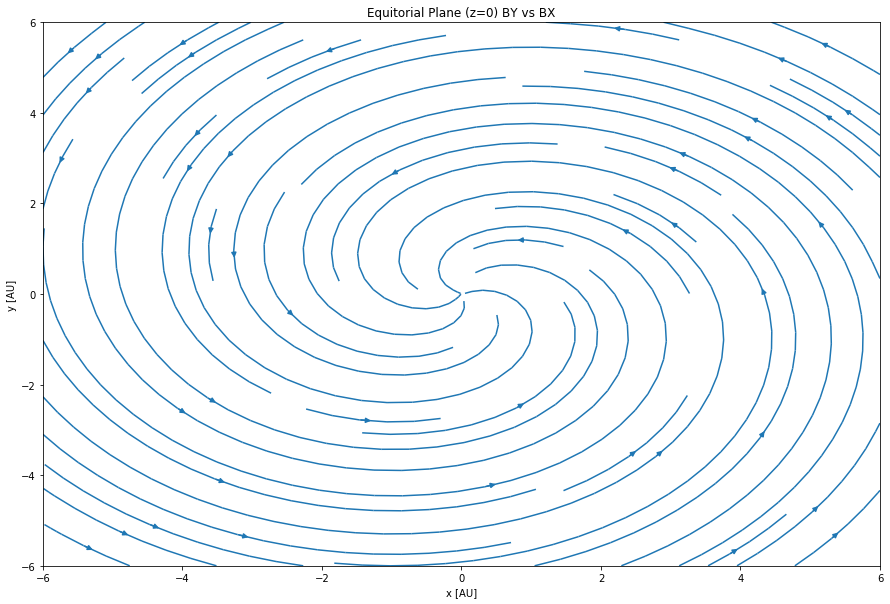

In [116]:
# plot it
plt.figure(figsize=(15,10))
plt.xlim(-w,w) # actually x-axis
plt.ylim(-w,w) # actually y-axis
plt.xlabel('x [AU]')
plt.ylabel('y [AU]')
plt.title('Equitorial Plane (z=0) BY vs BX')
plt.streamplot(X,Y,BX,BY)

# BALLS

In [4]:
x = np.linspace(-5,5,20)
y = np.linspace(-5,5,20)
z = np.linspace(-5,5,20)
X,Y,Z = np.meshgrid(x,y,z, indexing='ij')
shape = X.shape
x = X.flatten()
y = Y.flatten()
z = Z.flatten()
size = x.size

bx = np.zeros(size)
by = np.zeros(size)
bz = np.zeros(size)
for i, (ix, iy, iz) in enumerate(zip(x, y, z)):
    position = np.array([ix, iy, iz])
    bx[i], by[i], bz[i] = Bfield.cartesianTesla(position)

X = x.reshape(shape)
Y = y.reshape(shape)
Z = z.reshape(shape)  
BX = bx.reshape(shape)
BY = by.reshape(shape)
BZ = bz.reshape(shape)

#fig = plt.figure(figsize=(15,15))
#ax = fig.gca(projection='3d')
#ax.quiver(x,y,z,bx,by,bz,color='b',length=1,normalize=True)
#plt.xlim(-2,2)
#plt.ylim(-2,2)
#plt.zlim(-2,2)
#plt.xlabel('x [AU]')
#plt.ylabel('y [AU]')
#plt.zlabel('z [AU]')
#plt.title('Balls!')
#plt.show()

NameError: name 'Bfield' is not defined

In [ ]:
from mayavi import mlab
fig = mlab.figure(1, size=(1000,1000))
field = mlab.pipeline.vector_field(BX, BY, BZ)
magnitude = mlab.pipeline.extract_vector_norm(field)
field_lines = mlab.pipeline.streamline(magnitude)
mlab.show()

In [16]:

#contours = mlab.pipeline.iso_surface(magnitude,
#                                     conours=[.01,.8,3.8,],
#                                     transparent=True,
#                                     opacity=.4,
#                                     colormap='YlGnBu',
#                                     vmin=0,vmax=2)